<a href="https://colab.research.google.com/github/Manvi1718/FER_XAI/blob/main/score_cam_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=99316ae81c51871830ab01a377c3aaec6bd2e86e70629dccb5606996bb204321
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import torch
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as model
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
import os
import cv2
from efficientnet_pytorch import EfficientNet

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define transformations, including grayscale and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the root directory of your train and test data in Google Drive
test_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/test_d'
train_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/train_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]


class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label
# Load your custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [6]:
import torchvision.models as model
dir(model)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [7]:
# Load Efficientnet model
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet_model._fc = nn.Linear(efficientnet_model._fc.in_features, 7)
efficientnet_state_dict = torch.load('/content/drive/MyDrive/Emotion_Analysis_Model/efficientnet_model.pth')
efficientnet_model.eval()
efficientnet_model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 253MB/s]
<ipython-input-7-b18ca41aad8e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [30]:
class ScoreCAM:
    def __init__(self, model, target_layer, transform=None):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hooks = []
        self.register_hooks()
        self.transform = transform if transform else ToPILImage()

    def register_hooks(self):
        # Register a forward hook to capture the activations of the target layer
        def forward_hook(module, input, output):
            self.activations = output
            output.retain_grad()  # Retain gradients for backward pass

        # Register a backward hook to capture the gradients of the target layer
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                # Register hooks for the specified target layer
                self.hooks.append(module.register_forward_hook(forward_hook))
                self.hooks.append(module.register_backward_hook(backward_hook))

    def generate_cam(self, input_tensor, class_idx=None):
        # Ensure the model is in evaluation mode
        self.model.eval()

        # Perform a forward pass to get activations and output
        self.model.zero_grad()  # Zero out gradients to avoid accumulation
        output = self.model(input_tensor)

        # If no class index is provided, use the class with the highest score
        if class_idx is None:
            class_idx = output.argmax().item()

        # Get the score for the target class and backpropagate
        target = output[:, class_idx]
        target.backward(retain_graph=True)

        # Check if activations and gradients were captured
        if self.activations is None or self.gradients is None:
            raise ValueError("Activations or gradients were not captured. Check if the target layer name is correct.")

        # Move activations and gradients to CPU and detach from graph
        activations = self.activations.cpu().detach().numpy()[0]
        gradients = self.gradients.cpu().detach().numpy()[0]

        # Create the Score-CAM map
        cam_map = np.zeros_like(activations[0, :, :])

        # Calculate the weighted sum of gradients and activations
        for i in range(activations.shape[0]):
            cam_map += gradients[i, :, :] * activations[i, :, :]

        # Resize to match the input image size
        h, w = input_tensor.shape[2], input_tensor.shape[3]
        cam_map = cv2.resize(cam_map, (w, h))

        # Normalize the CAM to [0, 1]
        cam_map = np.maximum(cam_map, 0)
        cam_map = cam_map / cam_map.max() if cam_map.max() != 0 else cam_map

        return cam_map

    def __del__(self):
        # Remove hooks when the object is deleted
        for hook in self.hooks:
            hook.remove()

In [31]:
# Image folder path
image_folder = '/content/drive/MyDrive/FER_Images'

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [36]:
# Initialize ScoreCAM for the target layer
target_layer='_conv_head'
score_cam = ScoreCAM(model=efficientnet_model, target_layer=target_layer)

In [37]:
emotion_images = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
results = {}

for emotion in emotion_images:
    img_path = os.path.join(image_folder, f"{emotion}.png")  # Adjust path if your naming is different
    if not os.path.exists(img_path):
        continue  # Skip if the image doesn't exist

    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    score_cam_map = score_cam.generate_cam(input_tensor)

    # Convert original and heatmap for visualization
    original_img = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * score_cam_map), cv2.COLORMAP_INFERNO)
    heatmap_overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    # Store results for visualization
    results[emotion] = (original_img, heatmap_overlay, heatmap)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


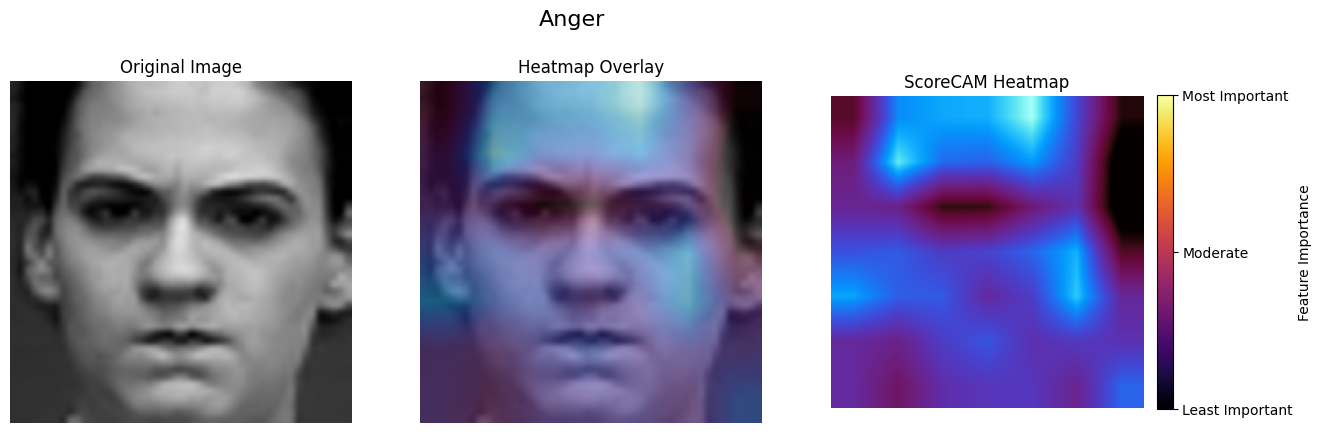

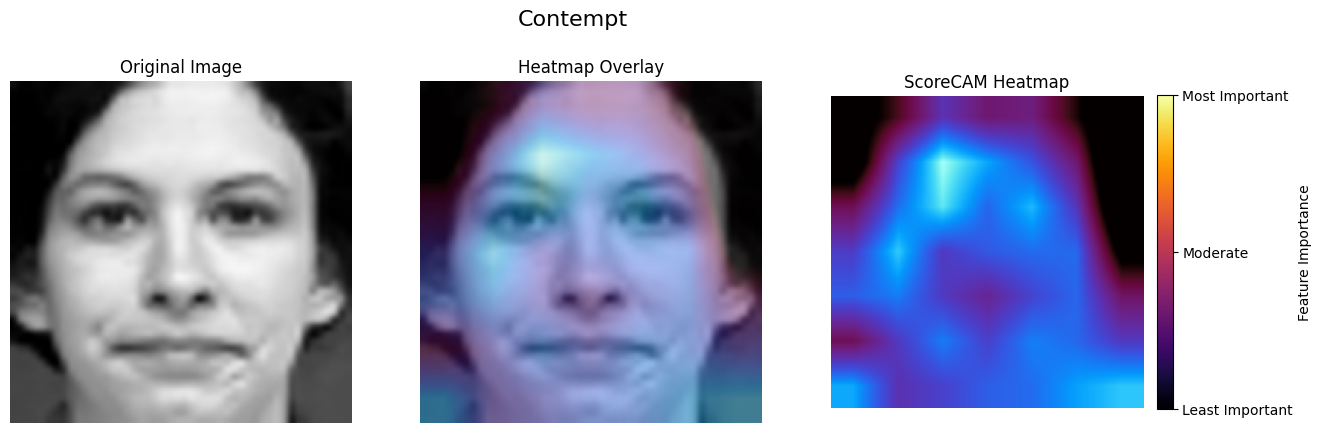

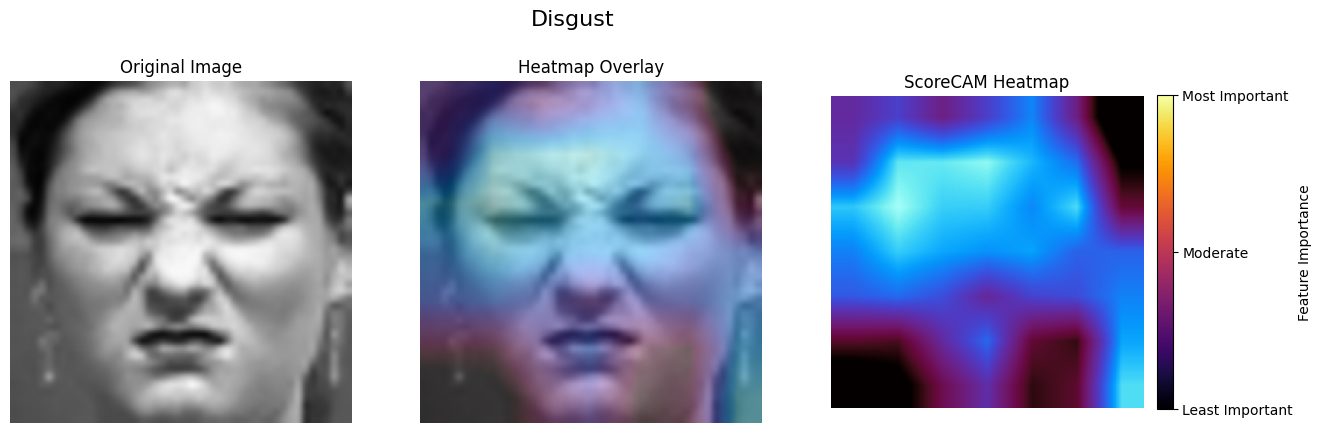

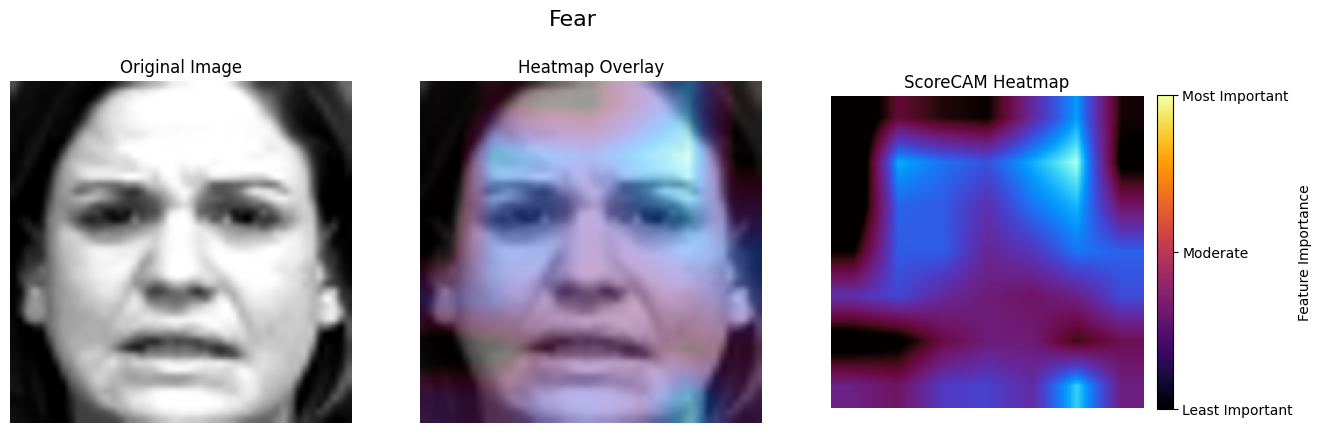

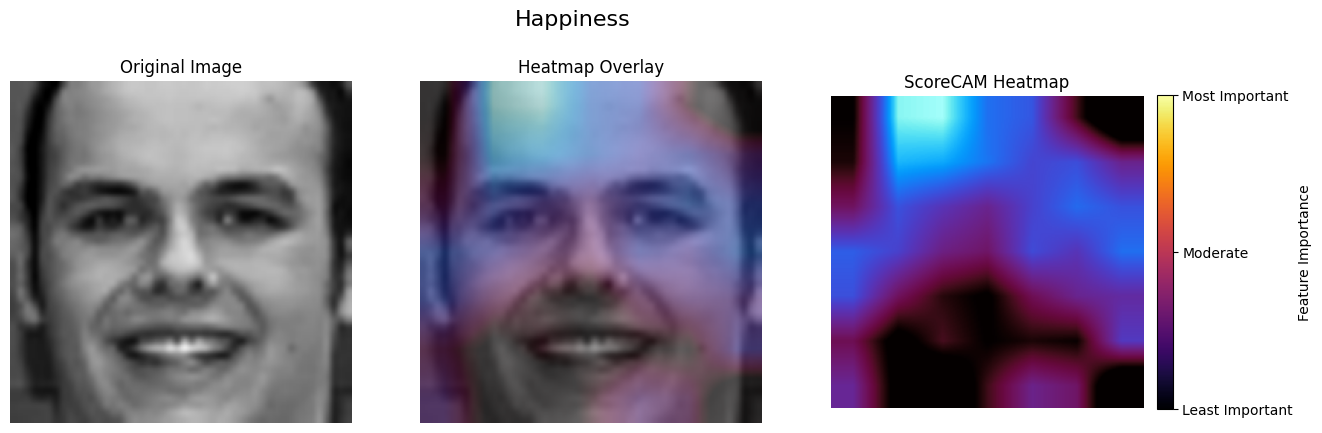

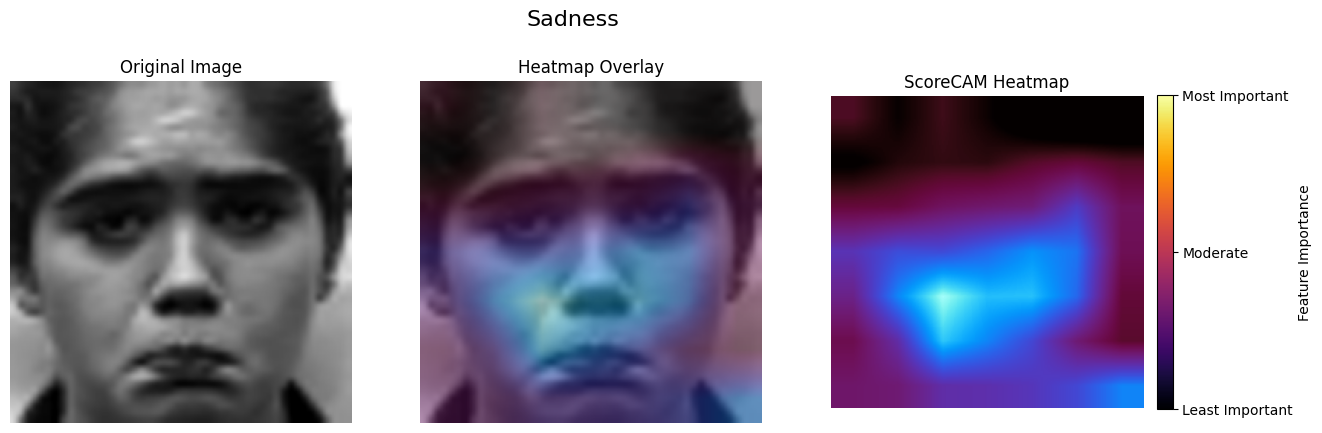

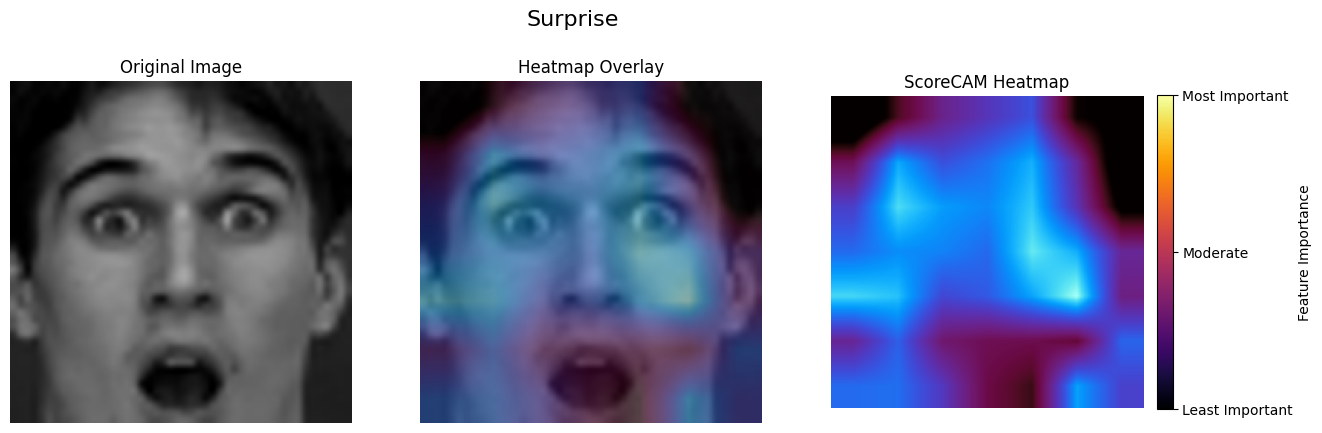

In [38]:
# Plotting with colorbar
for emotion, (original_img, heatmap_overlay, heatmap) in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(emotion.capitalize(), fontsize=16)

    # Original Image
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Heatmap Overlay
    ax[1].imshow(heatmap_overlay)
    ax[1].set_title('Heatmap Overlay')
    ax[1].axis('off')

    # Standalone Heatmap with Colorbar (using 'inferno' colormap)
    heatmap_img = ax[2].imshow(heatmap, cmap='inferno')  # Apply 'inferno' colormap
    ax[2].set_title('ScoreCAM Heatmap')
    ax[2].axis('off')

    # Add colorbar matching the 'inferno' colormap
    cbar = fig.colorbar(heatmap_img, ax=ax[2], fraction=0.046, pad=0.04)
    cbar.set_label('Feature Importance')
    cbar.set_ticks([0, 127.5, 255])  # Add ticks to represent least to most important
    cbar.set_ticklabels(['Least Important', 'Moderate', 'Most Important'])

    plt.show()